# 2D MaxPooling Layer from Scratch

This notebook implements a 2D MaxPooling layer using only NumPy, with both forward and backward propagation.


## Imports


In [1]:
import numpy as np
import matplotlib.pyplot as plt

print("Libraries imported successfully!")


Libraries imported successfully!


## MaxPool2D Class Implementation


In [2]:
class MaxPool2D:
    """
    2D MaxPooling Layer implemented from scratch using NumPy.
    
    Parameters:
    -----------
    pool_size : int or tuple
        Size of the pooling window (pool_h, pool_w)
    stride : int or tuple, optional
        Stride of the pooling operation (default: None, uses pool_size)
    """
    
    def __init__(self, pool_size, stride=None):
        # Handle pool_size
        if isinstance(pool_size, int):
            pool_size = (pool_size, pool_size)
        self.pool_h, self.pool_w = pool_size
        
        # Handle stride (default to pool_size if not provided)
        if stride is None:
            stride = pool_size
        if isinstance(stride, int):
            stride = (stride, stride)
        self.stride_h, self.stride_w = stride
        
        # Storage for backward pass
        self.input_shape = None
        self.max_indices = None  # Store indices of maximum values
    
    def forward(self, X):
        """
        Forward propagation of MaxPool2D.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Input feature map of shape (N, C, H_in, W_in)
            
        Returns:
        --------
        Y : numpy.ndarray
            Output feature map of shape (N, C, H_out, W_out)
        """
        N, C, H_in, W_in = X.shape
        self.input_shape = X.shape
        
        # Calculate output dimensions
        H_out = (H_in - self.pool_h) // self.stride_h + 1
        W_out = (W_in - self.pool_w) // self.stride_w + 1
        
        # Initialize output
        Y = np.zeros((N, C, H_out, W_out))
        
        # Store indices for backward pass
        # max_indices will store the flat index of max value in each pooling window
        self.max_indices = np.zeros((N, C, H_out, W_out), dtype=np.int32)
        
        # For each sample and channel
        for n in range(N):
            for c in range(C):
                # For each output position
                for i in range(H_out):
                    for j in range(W_out):
                        # Define pooling window boundaries
                        h_start = i * self.stride_h
                        h_end = h_start + self.pool_h
                        w_start = j * self.stride_w
                        w_end = w_start + self.pool_w
                        
                        # Extract pooling region
                        pool_region = X[n, c, h_start:h_end, w_start:w_end]
                        
                        # Find maximum value and its index
                        max_val = np.max(pool_region)
                        Y[n, c, i, j] = max_val
                        
                        # Find the position of max value within the pool region
                        # We need to store this as a flat index relative to the input feature map
                        max_pos_in_region = np.unravel_index(
                            np.argmax(pool_region), pool_region.shape
                        )
                        
                        # Convert to absolute position in input feature map
                        max_h = h_start + max_pos_in_region[0]
                        max_w = w_start + max_pos_in_region[1]
                        
                        # Store as flat index in the (H_in, W_in) space
                        self.max_indices[n, c, i, j] = max_h * W_in + max_w
        
        return Y
    
    def backward(self, dY):
        """
        Backward propagation of MaxPool2D.
        
        Parameters:
        -----------
        dY : numpy.ndarray
            Gradient of loss w.r.t. output Y, shape (N, C, H_out, W_out)
            
        Returns:
        --------
        dX : numpy.ndarray
            Gradient of loss w.r.t. input X, shape (N, C, H_in, W_in)
        """
        if self.input_shape is None:
            raise ValueError("Forward pass must be called before backward pass")
        
        N, C, H_in, W_in = self.input_shape
        
        # Initialize gradient w.r.t. input (all zeros initially)
        dX = np.zeros((N, C, H_in, W_in))
        
        # Calculate output dimensions
        H_out = (H_in - self.pool_h) // self.stride_h + 1
        W_out = (W_in - self.pool_w) // self.stride_w + 1
        
        # For each sample and channel
        for n in range(N):
            for c in range(C):
                # For each output position
                for i in range(H_out):
                    for j in range(W_out):
                        # Get the stored index of the maximum value
                        flat_idx = self.max_indices[n, c, i, j]
                        
                        # Convert flat index back to 2D coordinates
                        max_h = flat_idx // W_in
                        max_w = flat_idx % W_in
                        
                        # Pass gradient only to the position that was the maximum
                        dX[n, c, max_h, max_w] += dY[n, c, i, j]
        
        return dX


## Numerical Example

Let's test our implementation with a specific example:

**Input:**
- Shape: (N=1, C=1, H=4, W=4)
- X = [[1, 3, 2, 1],
       [4, 6, 5, 2],
       [3, 2, 1, 0],
       [1, 2, 3, 4]]

**Pooling parameters:**
- Pool size: (2, 2)
- Stride: 2


In [3]:
# Define input
X = np.array([[[[1, 3, 2, 1],
                [4, 6, 5, 2],
                [3, 2, 1, 0],
                [1, 2, 3, 4]]]], dtype=np.float32)

print("Input X shape:", X.shape)
print("\nInput X:")
print(X[0, 0])


Input X shape: (1, 1, 4, 4)

Input X:
[[1. 3. 2. 1.]
 [4. 6. 5. 2.]
 [3. 2. 1. 0.]
 [1. 2. 3. 4.]]


In [4]:
# Create MaxPool2D layer
maxpool = MaxPool2D(pool_size=(2, 2), stride=2)

print("Pool size:", (maxpool.pool_h, maxpool.pool_w))
print("Stride:", (maxpool.stride_h, maxpool.stride_w))


Pool size: (2, 2)
Stride: (2, 2)


### Forward Pass


In [5]:
# Forward pass
Y = maxpool.forward(X)

print("Output Y shape:", Y.shape)
print("\nPooled Output Y:")
print(Y[0, 0])
print("\nMax indices stored:")
print("Shape:", maxpool.max_indices.shape)
print("Values:")
print(maxpool.max_indices[0, 0])


Output Y shape: (1, 1, 2, 2)

Pooled Output Y:
[[6. 5.]
 [3. 4.]]

Max indices stored:
Shape: (1, 1, 2, 2)
Values:
[[ 5  6]
 [ 8 15]]


### Detailed Analysis of Forward Pass

Let's manually verify each pooling window:


In [6]:
print("Detailed Forward Pass Analysis:\n")
print("Input X:")
print(X[0, 0])
print("\n" + "="*50)

# Calculate output dimensions manually
H_in, W_in = 4, 4
pool_h, pool_w = 2, 2
stride_h, stride_w = 2, 2
H_out = (H_in - pool_h) // stride_h + 1
W_out = (W_in - pool_w) // stride_w + 1

input_data = X[0, 0]
print(f"\nPooling windows ({pool_h}x{pool_w}) with stride ({stride_h}, {stride_w}):\n")

for i in range(H_out):
    for j in range(W_out):
        h_start = i * stride_h
        h_end = h_start + pool_h
        w_start = j * stride_w
        w_end = w_start + pool_w
        
        window = input_data[h_start:h_end, w_start:w_end]
        max_val = np.max(window)
        max_pos = np.unravel_index(np.argmax(window), window.shape)
        abs_pos = (h_start + max_pos[0], w_start + max_pos[1])
        
        print(f"Window [{i}, {j}]:")
        print(f"  Region: rows {h_start}:{h_end}, cols {w_start}:{w_end}")
        print(f"  Window values:\n  {window}")
        print(f"  Maximum value: {max_val}")
        print(f"  Max position in window: {max_pos}")
        print(f"  Max position in input: {abs_pos}")
        print()

print("="*50)
print("\nFinal Output Y:")
print(Y[0, 0])


Detailed Forward Pass Analysis:

Input X:
[[1. 3. 2. 1.]
 [4. 6. 5. 2.]
 [3. 2. 1. 0.]
 [1. 2. 3. 4.]]


Pooling windows (2x2) with stride (2, 2):

Window [0, 0]:
  Region: rows 0:2, cols 0:2
  Window values:
  [[1. 3.]
 [4. 6.]]
  Maximum value: 6.0
  Max position in window: (1, 1)
  Max position in input: (1, 1)

Window [0, 1]:
  Region: rows 0:2, cols 2:4
  Window values:
  [[2. 1.]
 [5. 2.]]
  Maximum value: 5.0
  Max position in window: (1, 0)
  Max position in input: (1, 2)

Window [1, 0]:
  Region: rows 2:4, cols 0:2
  Window values:
  [[3. 2.]
 [1. 2.]]
  Maximum value: 3.0
  Max position in window: (0, 0)
  Max position in input: (2, 0)

Window [1, 1]:
  Region: rows 2:4, cols 2:4
  Window values:
  [[1. 0.]
 [3. 4.]]
  Maximum value: 4.0
  Max position in window: (1, 1)
  Max position in input: (3, 3)


Final Output Y:
[[6. 5.]
 [3. 4.]]


### Backward Pass


In [7]:
# Define gradient w.r.t. output (all ones as specified)
dY = np.ones_like(Y)

print("Gradient dY shape:", dY.shape)
print("\nGradient dY:")
print(dY[0, 0])


Gradient dY shape: (1, 1, 2, 2)

Gradient dY:
[[1. 1.]
 [1. 1.]]


In [8]:
# Backward pass
dX = maxpool.backward(dY)

print("Gradient dX shape:", dX.shape)
print("\nBackpropagated Gradient dX:")
print(dX[0, 0])


Gradient dX shape: (1, 1, 4, 4)

Backpropagated Gradient dX:
[[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]


### Detailed Analysis of Backward Pass

Let's verify how gradients flow back:


In [9]:
print("Detailed Backward Pass Analysis:\n")
print("Gradient dY (gradient w.r.t. output):")
print(dY[0, 0])
print("\n" + "="*50)
print("\nFor each output position, gradient flows back to max position:\n")

for i in range(H_out):
    for j in range(W_out):
        # Get the stored index of the maximum value
        flat_idx = maxpool.max_indices[0, 0, i, j]
        max_h = flat_idx // W_in
        max_w = flat_idx % W_in
        
        print(f"Output position [{i}, {j}] (gradient = {dY[0, 0, i, j]}):")
        print(f"  Flows back to input position [{max_h}, {max_w}]")
        print(f"  dX[{max_h}, {max_w}] = {dX[0, 0, max_h, max_w]}")
        print()

print("="*50)
print("\nFinal Gradient dX (gradient w.r.t. input):")
print(dX[0, 0])
print("\nNote: Only positions that were maxima receive gradients (others are zero)")


Detailed Backward Pass Analysis:

Gradient dY (gradient w.r.t. output):
[[1. 1.]
 [1. 1.]]


For each output position, gradient flows back to max position:

Output position [0, 0] (gradient = 1.0):
  Flows back to input position [1, 1]
  dX[1, 1] = 1.0

Output position [0, 1] (gradient = 1.0):
  Flows back to input position [1, 2]
  dX[1, 2] = 1.0

Output position [1, 0] (gradient = 1.0):
  Flows back to input position [2, 0]
  dX[2, 0] = 1.0

Output position [1, 1] (gradient = 1.0):
  Flows back to input position [3, 3]
  dX[3, 3] = 1.0


Final Gradient dX (gradient w.r.t. input):
[[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]]

Note: Only positions that were maxima receive gradients (others are zero)


### Visualization


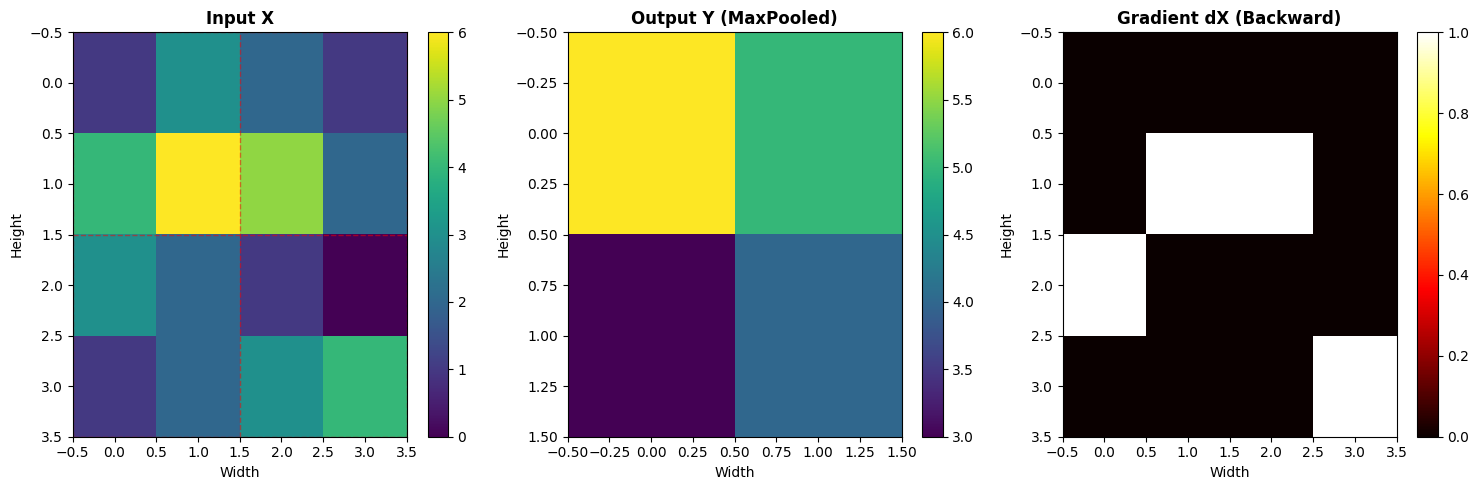


Input X values:
Row 0: [1. 3. 2. 1.]
Row 1: [4. 6. 5. 2.]
Row 2: [3. 2. 1. 0.]
Row 3: [1. 2. 3. 4.]

Output Y values:
Row 0: [6. 5.]
Row 1: [3. 4.]

Gradient dX values:
Row 0: [0. 0. 0. 0.]
Row 1: [0. 1. 1. 0.]
Row 2: [1. 0. 0. 0.]
Row 3: [0. 0. 0. 1.]


In [10]:
# Visualize forward and backward passes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Input
im1 = axes[0].imshow(X[0, 0], cmap='viridis', aspect='auto')
axes[0].set_title('Input X', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')
plt.colorbar(im1, ax=axes[0])

# Add grid lines to show pooling windows
for i in range(0, 5, 2):
    axes[0].axhline(i-0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[0].axvline(i-0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Output
im2 = axes[1].imshow(Y[0, 0], cmap='viridis', aspect='auto')
axes[1].set_title('Output Y (MaxPooled)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Width')
axes[1].set_ylabel('Height')
plt.colorbar(im2, ax=axes[1])

# Gradient
im3 = axes[2].imshow(dX[0, 0], cmap='hot', aspect='auto')
axes[2].set_title('Gradient dX (Backward)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Width')
axes[2].set_ylabel('Height')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

# Print values
print("\nInput X values:")
for i, row in enumerate(X[0, 0]):
    print(f"Row {i}: {row}")

print("\nOutput Y values:")
for i, row in enumerate(Y[0, 0]):
    print(f"Row {i}: {row}")

print("\nGradient dX values:")
for i, row in enumerate(dX[0, 0]):
    print(f"Row {i}: {row}")


In [11]:
# Test with multiple channels and samples
X_multi = np.random.randn(2, 3, 8, 8)  # 2 samples, 3 channels, 8x8
maxpool_test = MaxPool2D(pool_size=3, stride=2)

print("Input shape:", X_multi.shape)
print("Pool size:", (maxpool_test.pool_h, maxpool_test.pool_w))
print("Stride:", (maxpool_test.stride_h, maxpool_test.stride_w))

Y_multi = maxpool_test.forward(X_multi)
print("\nOutput shape:", Y_multi.shape)

dY_multi = np.random.randn(*Y_multi.shape)
dX_multi = maxpool_test.backward(dY_multi)
print("Gradient dX shape:", dX_multi.shape)

print("\nTest passed! Multi-channel example works correctly.")


Input shape: (2, 3, 8, 8)
Pool size: (3, 3)
Stride: (2, 2)

Output shape: (2, 3, 3, 3)
Gradient dX shape: (2, 3, 8, 8)

Test passed! Multi-channel example works correctly.


## Summary

This implementation successfully demonstrates:

1. ✅ **Forward Pass**: Correctly computes max pooling with configurable pool size and stride
2. ✅ **Index Storage**: Stores positions of maximum values for efficient backward pass
3. ✅ **Backward Pass**: Correctly propagates gradients only to maximum positions
4. ✅ **Numerical Example**: Verified with the provided example input

**Key Points:**
- Max pooling reduces spatial dimensions while preserving the strongest features
- During backward pass, gradients only flow to the positions that were selected as maxima
- All other positions receive zero gradient (they didn't contribute to the output)
